<div align="center">

# National Tsing Hua University

### Fall 2023

#### 11210IPT 553000

#### Deep Learning in Biomedical Optical Imaging

## Report
</div>


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Download train and val dataset
!wget -q -O report_train.npy "https://www.dropbox.com/scl/fi/30dlbblp7wytcvoy05col/report_train.npy?rlkey=jx100qoz5n1d654v2mi32i9aj&dl=1"
!wget -q -O report_val.npy "https://www.dropbox.com/scl/fi/oo6g1yqhbjm22wffeddgv/report_val.npy?rlkey=9rqe0rucjhrbzv3x7xbs5047z&dl=1"

## A. Data Loading and Preprocessing

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np

# Load Dataset
x_train = np.transpose(np.load('report_train.npy'), (0, 3, 1, 2))
x_val = np.transpose(np.load('report_val.npy'), (0, 3, 1, 2))

print(f'Shape of x_train: {x_train.shape}')
print(f'Shape of x_val: {x_val.shape}')

num_classes = 6

# Create labels
y_train = np.concatenate([np.full(425, i) for i in range(num_classes)])
y_val = np.concatenate([np.full(100, i) for i in range(num_classes)])

# Convert to PyTorch tensors
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).long()

x_val = torch.from_numpy(x_val).float()
y_val = torch.from_numpy(y_val).long()

Shape of x_train: (2550, 3, 150, 150)
Shape of x_val: (600, 3, 150, 150)


In [ ]:
batch_size = 32

# Create datasets
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f'Number of samples in train and validation are {len(train_loader.dataset)} and {len(val_loader.dataset)}.')
print(f'X_train: max value is {x_train.max().item()}, min value is {x_train.min().item()}, data type is {x_train.dtype}.')

Number of samples in train and validation are 2550 and 600.
X_train: max value is 255.0, min value is 0.0, data type is torch.float32.


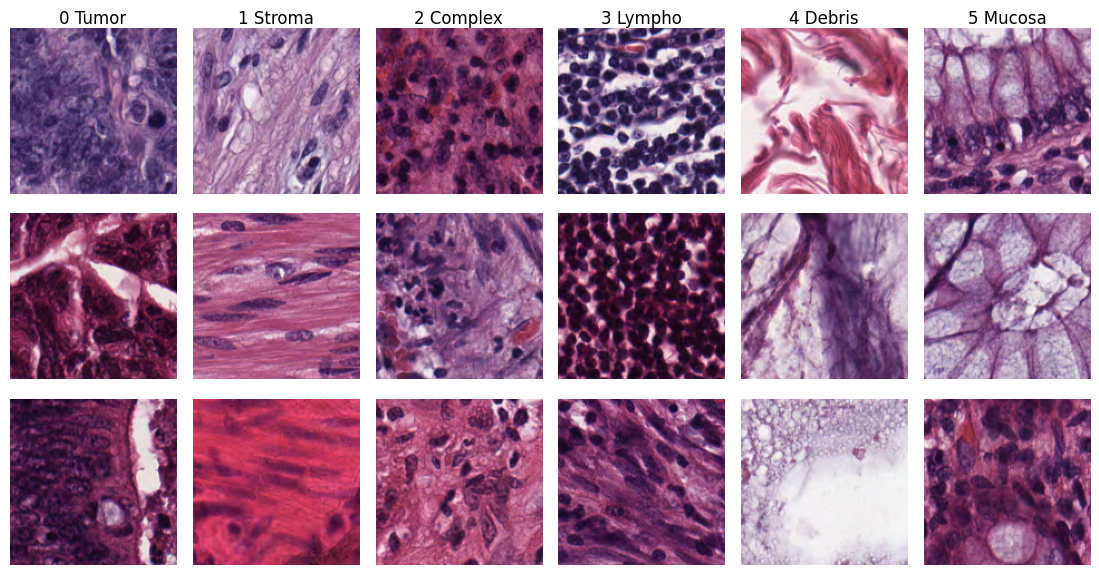

In [ ]:
import matplotlib.pyplot as plt
import random

class_names = ['Tumor', 'Stroma', 'Complex', 'Lympho', 'Debris', 'Mucosa']

num_classes = 6
samples_per_class = 3

fig, axes = plt.subplots(samples_per_class, num_classes, figsize=(12, 6))

plt.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95, wspace=0.1, hspace=0.1)

for class_idx in range(num_classes):
    indices_of_class = np.where(y_train == class_idx)[0]
    random_indices = random.sample(list(indices_of_class), samples_per_class)

    for i in range(samples_per_class):
        ax = axes[i, class_idx]
        img = x_train[random_indices[i]].numpy().transpose((1, 2, 0))
        img = img / img.max()
        ax.imshow(img)
        ax.axis('off')

        if i == 0:
            ax.set_title(f'{class_idx} {class_names[class_idx]}', pad=3)

plt.show()

##Self-defined fiunction

In [ ]:
import os
import json
import torch
import matplotlib.pyplot as plt

class ModelData():

    def __init__(self, name, dataset_name):
        ''' 使用範例:
            md_data = ModelData(name="Model", dataset_name=[""])
            md_data.model_path="/content/drive"
            md_data.add_data(epoch=0, loss=0.5)
            md_data.reset_data(time=str(datetime.datetime.now()))
            md_data.save_data()
        '''
        self.model_data_dic = {}
        self.reset_data(name=name, dataset_name=dataset_name)
        self.model_path = "."

    def reset_path_and_folder(self, model_path):
        os.makedirs(model_path, exist_ok=True)
        self.model_path = model_path

    def reset_data(self, **kwargs):
        for kwarg, value in kwargs.items():
            setattr(self, kwarg, value)  # 設置實例的屬性
            self.model_data_dic[kwarg] = value  # 更新 self.model_data_dic 字典

    def add_data(self, **kwargs):
        for kwarg, value in kwargs.items():
            setattr(self, kwarg, value)
            if kwarg in self.model_data_dic and isinstance(self.model_data_dic[kwarg], list):
                self.model_data_dic[kwarg].append(value)
            else:
                self.model_data_dic[kwarg] = [value]

    def save_data(self, path=None, name=None):
        if path is None:
            path = self.model_path
        if name is None:
            name = self.name

        # 確保目錄存在，如果不存在則創建
        os.makedirs(path, exist_ok=True)

        file_path = f"{path}/{name}.json"
        existing_model_list = []

        if os.path.exists(file_path):
            with open(file_path, 'r') as f:
                existing_model_list = json.load(f)

        existing_model_list.append(self.model_data_dic)

        with open(file_path, 'w') as f:
            json.dump(existing_model_list, f, indent=4)

        print(f"Successfully dumped data into {file_path}")

    def read_data(self, model_name_list, model_root_path, mode="wm"):
        existing_model_list = []
        weight_list = []

        for name in model_name_list:
            if not name:  # Skip empty names
                continue

            file_path = f"{model_root_path}/{name}/{name}.json"  # 使用 model_root_path
            weight_path = f"{model_root_path}/{name}/{name}.pth"  # 使用 model_root_path

            print(f"Trying to read JSON from: {file_path}")  # 調試信息
            print(f"Trying to read weights from: {weight_path}")  # 調試信息

            if os.path.exists(file_path):
                with open(file_path, 'r') as f:
                    existing_model_list.append(json.load(f))
            else:
                print(f"File {file_path} does not exist.")

            if os.path.exists(weight_path):
                weight_list.append(torch.load(weight_path))
            else:
                print(f"Weight file {weight_path} does not exist.")

        if mode == "w":
            return weight_list
        if mode == "m":
            return existing_model_list
        else:
            return weight_list, existing_model_list

    def compare_images(self, existing_model_list):
        for model_data in existing_model_list:
            for each_model_data in model_data:
                fig, ax = plt.subplots(1, 2, figsize=(15, 5))

                # Plotting training and validation accuracy
                ax[0].plot(each_model_data["train_accuracies"])
                ax[0].plot(each_model_data["val_accuracies"])
                ax[0].set_title(f'{each_model_data["name"]} Accuracy')
                ax[0].set_xlabel('Epochs')
                ax[0].set_ylabel('Accuracy')
                ax[0].legend(['Train', 'Val'])

                # Plotting training and validation loss
                ax[1].plot(each_model_data["train_losses"])
                ax[1].plot(each_model_data["val_losses"])
                ax[1].set_title(f'{each_model_data["name"]} Loss')
                ax[1].set_xlabel('Epochs')
                ax[1].set_ylabel('Loss')
                ax[1].legend(['Train', 'Val'])

                plt.show()

    def change_data(self, data_path, key, value):
        if os.path.exists(data_path):
            # 讀取現有的數據
            with open(data_path, 'r') as f:
                total_data = json.load(f)

            # 修改數據
            for i in total_data:
                i[key] = value

            # 寫回文件
            with open(data_path, 'w') as f:
                json.dump(total_data, f, indent=4)

## B. Defining Neural Networks

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
from torchvision.models import list_models

import numpy as np
all_models = list_models()
all_models

['alexnet',
 'convnext_base',
 'convnext_large',
 'convnext_small',
 'convnext_tiny',
 'deeplabv3_mobilenet_v3_large',
 'deeplabv3_resnet101',
 'deeplabv3_resnet50',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b2',
 'efficientnet_b3',
 'efficientnet_b4',
 'efficientnet_b5',
 'efficientnet_b6',
 'efficientnet_b7',
 'efficientnet_v2_l',
 'efficientnet_v2_m',
 'efficientnet_v2_s',
 'fasterrcnn_mobilenet_v3_large_320_fpn',
 'fasterrcnn_mobilenet_v3_large_fpn',
 'fasterrcnn_resnet50_fpn',
 'fasterrcnn_resnet50_fpn_v2',
 'fcn_resnet101',
 'fcn_resnet50',
 'fcos_resnet50_fpn',
 'googlenet',
 'inception_v3',
 'keypointrcnn_resnet50_fpn',
 'lraspp_mobilenet_v3_large',
 'maskrcnn_resnet50_fpn',
 'maskrcnn_resnet50_fpn_v2',
 'maxvit_t',
 'mc3_18',
 'mnasnet0_5',
 'mnasnet0_75',
 'mnasnet1_0',
 'mnasnet1_3',
 'mobilenet_v2',
 'mobilenet_v3_large',
 'mobilenet_v3_small',
 'mvit_v1_b',
 'mvit_v2_s',
 'quantized_googlenet',
 '

In [ ]:
md_data = ModelData(name="EfficientNetB4", dataset_name=["https://www.dropbox.com/scl/fi/30dlbblp7wytcvoy05col/report_train.npy?rlkey=jx100qoz5n1d654v2mi32i9aj&dl=1","https://www.dropbox.com/scl/fi/oo6g1yqhbjm22wffeddgv/report_val.npy?rlkey=9rqe0rucjhrbzv3x7xbs5047z&dl=1"])
md_data.reset_path_and_folder(f"/content/drive/MyDrive/Course/研一上/深度學習之於生醫/self-report/Model/{md_data.name}")

import datetime
traning_times = []

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

# # 1st model: ResNet18
# model = models.resnet18(weights='IMAGENET1K_V1')
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, num_classes)

# # 2nd model: AlexNet
# model = models.alexnet(weights='IMAGENET1K_V1')
# num_ftrs = model.classifier[6].in_features
# model.classifier[6] = nn.Linear(num_ftrs, num_classes)

# 3rd model: Inception v1
# model = models.googlenet(pretrained=True)
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, num_classes)

# 4th model: DenseNet121
# model = models.densenet121(weights='IMAGENET1K_V1')
# num_ftrs = model.classifier.in_features
# model.classifier = nn.Linear(num_ftrs, num_classes)

# # # 5th model: ResNet50
# model = models.resnet50(weights='IMAGENET1K_V1')
# num_ftrs_resnet50 = model.fc.in_features
# model.fc = nn.Linear(num_ftrs_resnet50, num_classes)


# 6th model: EfficientNetB4
from torchvision.models import EfficientNet_B4_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict

model = models.efficientnet_b4(weights=EfficientNet_B4_Weights.IMAGENET1K_V1)
num_ftrs_efficientnetb4 = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs_efficientnetb4, num_classes)

model = model.cuda()
print(model)


## C. Training the Neural Network

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
from tqdm.auto import tqdm

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

epochs = 30

best_val_loss = float('inf')
best_val_acc = -1

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=len(train_loader)*epochs, eta_min=0)

for epoch in tqdm(range(epochs)):
    # Training
    model.train()
    total_loss = 0.0
    train_correct = 0
    total_train_samples = 0

    for images, labels in train_loader:
        images = images.cuda()
        images = images / 255.
        labels = labels.cuda()
        optimizer.zero_grad()
        outputs = model(images)

        labels = labels.long()

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        train_predicted = outputs.argmax(-1)
        train_correct += (train_predicted.float() == labels).sum().item()
        total_train_samples += labels.size(0)

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = 100. * train_correct / total_train_samples

    # Validation
    model.eval()
    total_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.cuda()
            images = images / 255.
            labels = labels.cuda()
            outputs = model(images)

            labels = labels.long()

            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            predicted = outputs.argmax(-1)
            correct += (predicted.float() == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = 100. * correct / total

    # Learning rate update
    lr_scheduler.step()

    # Checkpoint
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss

    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        torch.save(model.state_dict(), f'{md_data.model_path}/{md_data.name}.pth')

    print(f'Epoch {epoch+1}/{epochs}, Train loss: {avg_train_loss:.4f}, Train acc: {train_accuracy:.2f}%, Val loss: {avg_val_loss:.4f}, Val acc: {val_accuracy:.2f}%, Best Val loss: {best_val_loss:.4f} Best Val acc: {best_val_acc:.2f}%')

    # Store performance
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    training_time = str(datetime.datetime.now())
    traning_times.append(training_time)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30, Train loss: 0.7173, Train acc: 75.45%, Val loss: 0.3031, Val acc: 88.67%, Best Val loss: 0.3031 Best Val acc: 88.67%
Epoch 2/30, Train loss: 0.1997, Train acc: 92.75%, Val loss: 0.2637, Val acc: 91.83%, Best Val loss: 0.2637 Best Val acc: 91.83%
Epoch 3/30, Train loss: 0.0929, Train acc: 97.14%, Val loss: 0.2867, Val acc: 91.67%, Best Val loss: 0.2637 Best Val acc: 91.83%
Epoch 4/30, Train loss: 0.0957, Train acc: 96.82%, Val loss: 0.3961, Val acc: 89.67%, Best Val loss: 0.2637 Best Val acc: 91.83%
Epoch 5/30, Train loss: 0.0771, Train acc: 97.37%, Val loss: 0.2949, Val acc: 91.50%, Best Val loss: 0.2637 Best Val acc: 91.83%
Epoch 6/30, Train loss: 0.0534, Train acc: 98.35%, Val loss: 0.2352, Val acc: 93.50%, Best Val loss: 0.2352 Best Val acc: 93.50%
Epoch 7/30, Train loss: 0.0521, Train acc: 98.47%, Val loss: 0.2238, Val acc: 93.67%, Best Val loss: 0.2238 Best Val acc: 93.67%
Epoch 8/30, Train loss: 0.0254, Train acc: 99.18%, Val loss: 0.2833, Val acc: 92.83%, Best Val lo

### Visualizing model performance

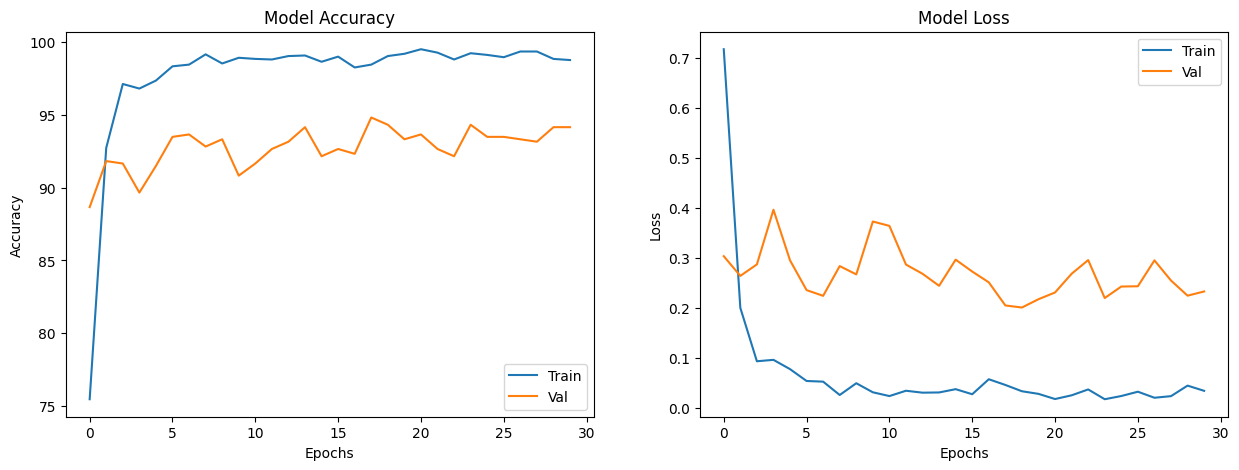

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plotting training and validation accuracy
ax[0].plot(train_accuracies)
ax[0].plot(val_accuracies)
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Val'])

# Plotting training and validation loss
ax[1].plot(train_losses)
ax[1].plot(val_losses)
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Val'])

plt.show()

## D. Evaluating Your Trained Model

### Process Test Dataset

In [ ]:
# Download test dataset,
!wget -q -O report_test.npy "https://www.dropbox.com/scl/fi/ufcagx2cvjmervgqrgwrt/report_test.npy?rlkey=fijueom5x54628ivpzeki2bt0&dl=1"

In [ ]:
x_test = np.transpose(np.load('report_test.npy'), (0, 3, 1, 2))
print(f'Shape of x_test: {x_test.shape}')

y_test = np.concatenate([np.full(100, i) for i in range(num_classes)])

x_test = torch.from_numpy(x_test).float()
y_test = torch.from_numpy(y_test).long()

print(f'x_test: max value is {x_test.max().item()}, min value is {x_test.min().item()}, data type is {x_test.dtype}.')

batch_size = 32

# Combine the images and labels into a dataset
test_dataset = TensorDataset(x_test, y_test)

# Create a dataloader to load data in batches. Set batch size to 32.
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

Shape of x_test: (600, 3, 150, 150)
x_test: max value is 255.0, min value is 0.0, data type is torch.float32.


### Load Trained Model and Evaluate

In [ ]:
# Load the trained weights
model.load_state_dict(torch.load(f'{md_data.model_path}/{md_data.name}.pth'))

# Set the model to evaluation mode
model.eval()

test_correct = 0
test_total = 0
total_loss = 0.0

with torch.no_grad():
    for images, labels in test_loader:

        images = images.cuda()
        images = images / 255.

        labels = labels.cuda()
        labels = labels.long()

        outputs = model(images)
        loss = criterion(outputs, labels)
        total_loss += loss.item()

        predicted = outputs.argmax(-1)
        test_correct += (predicted.float() == labels).sum().item()
        test_total += labels.size(0)

test_avg_loss = total_loss / len(test_loader)
test_accuracy = 100. * test_correct / test_total

print(f'test_avg_loss: {test_avg_loss}')
print(f'Test accuracy is {test_accuracy}%.')

test_avg_loss: 0.2651625973307283
Test accuracy is 92.83333333333333%.


In [ ]:
md_data.reset_data(train_losses=train_losses, val_losses=val_losses, train_accuracies=train_accuracies, val_accuracies=val_accuracies, traning_times=traning_times)
md_data.reset_data(model=str(model))
md_data.reset_data(test_data=["https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/test/test_normal.npy","https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/test/test_pneumonia.npy"])
md_data.reset_data(test_avg_loss=test_avg_loss, test_accuracy=test_accuracy)
md_data.save_data()

Successfully dumped data into /content/drive/MyDrive/Course/研一上/深度學習之於生醫/self-report/Model/EfficientNetB4/EfficientNetB4.json


Trying to read JSON from: /content/drive/MyDrive/Course/研一上/深度學習之於生醫/self-report/Model/ResNet18/ResNet18.json
Trying to read weights from: /content/drive/MyDrive/Course/研一上/深度學習之於生醫/self-report/Model/ResNet18/ResNet18.pth
Trying to read JSON from: /content/drive/MyDrive/Course/研一上/深度學習之於生醫/self-report/Model/AlexNet/AlexNet.json
Trying to read weights from: /content/drive/MyDrive/Course/研一上/深度學習之於生醫/self-report/Model/AlexNet/AlexNet.pth
Trying to read JSON from: /content/drive/MyDrive/Course/研一上/深度學習之於生醫/self-report/Model/googlenet/googlenet.json
Trying to read weights from: /content/drive/MyDrive/Course/研一上/深度學習之於生醫/self-report/Model/googlenet/googlenet.pth
Trying to read JSON from: /content/drive/MyDrive/Course/研一上/深度學習之於生醫/self-report/Model/DenseNet121/DenseNet121.json
Trying to read weights from: /content/drive/MyDrive/Course/研一上/深度學習之於生醫/self-report/Model/DenseNet121/DenseNet121.pth
Trying to read JSON from: /content/drive/MyDrive/Course/研一上/深度學習之於生醫/self-report/Model/ResNet50/ResN

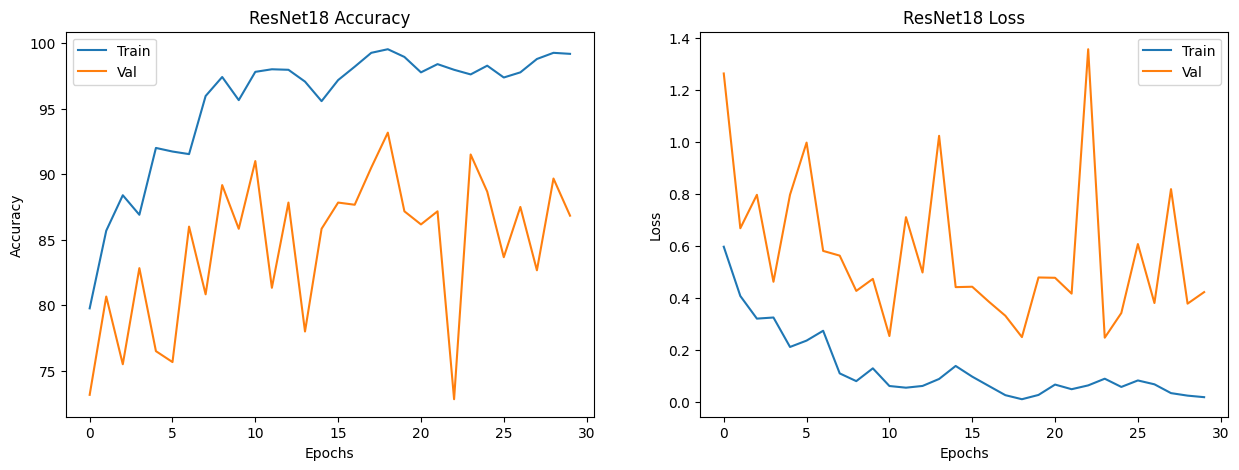

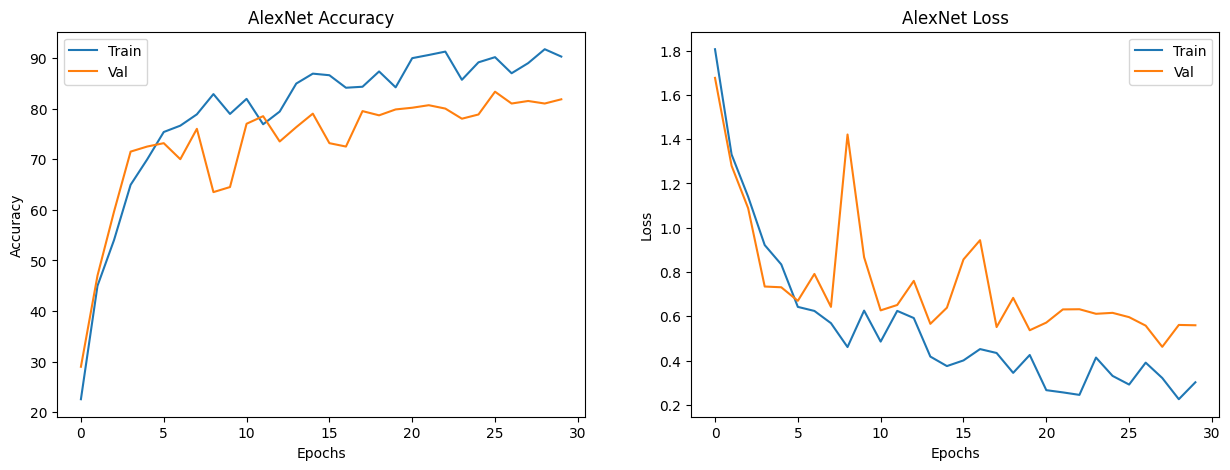

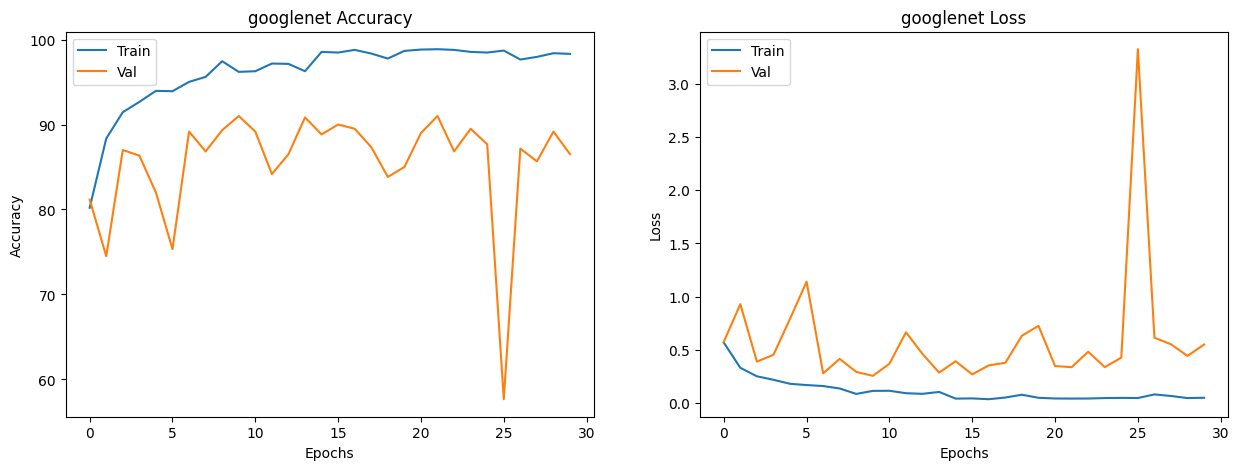

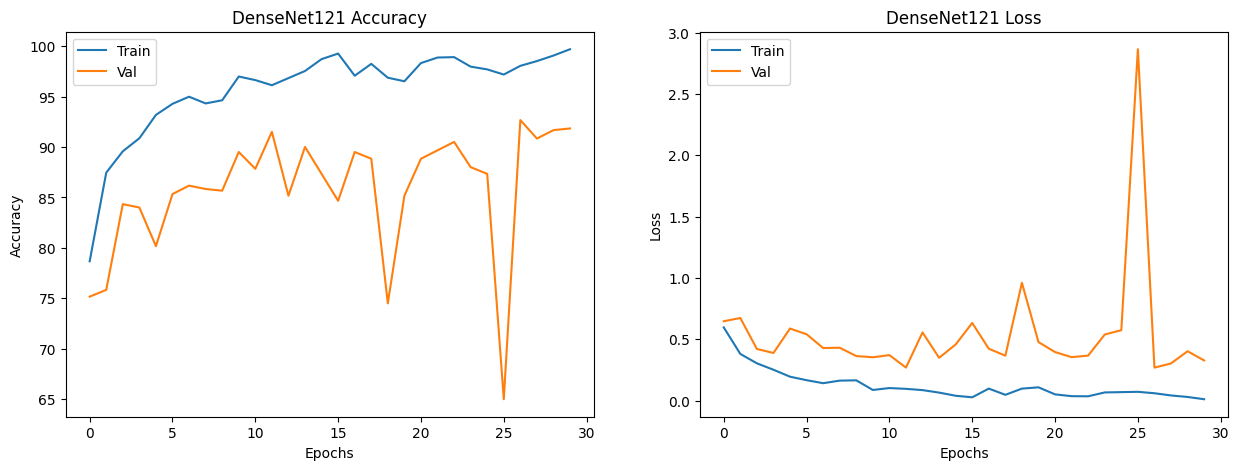

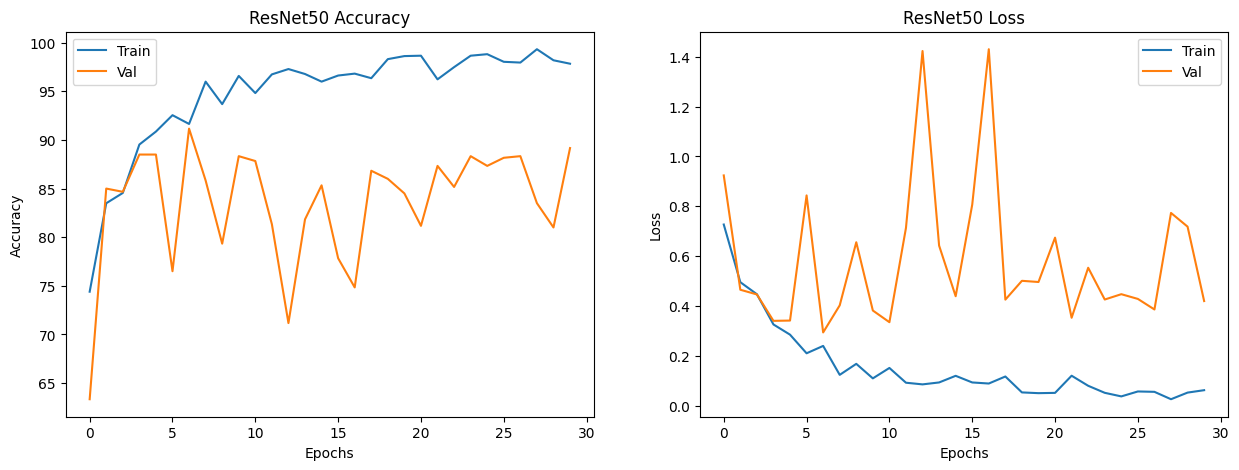

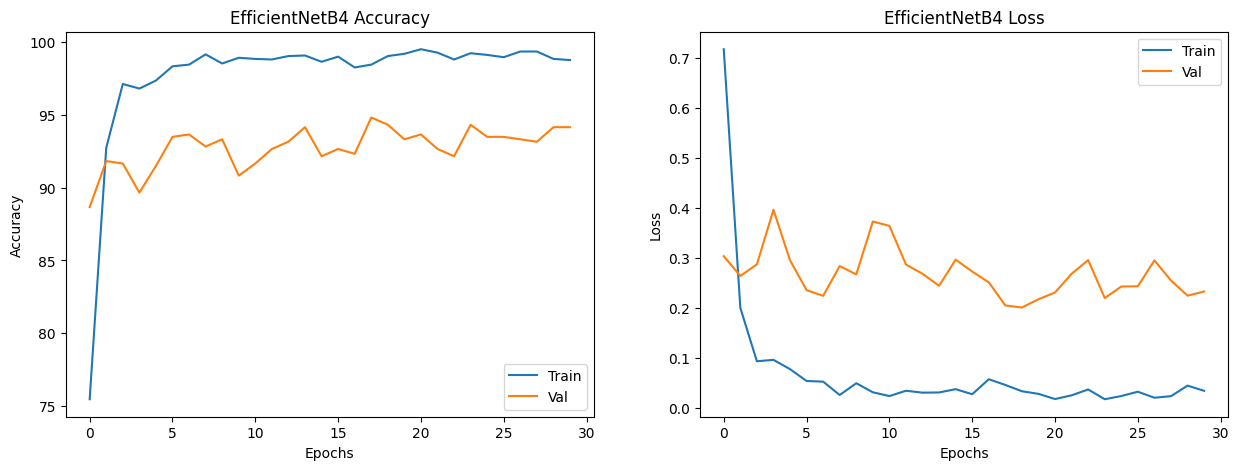

In [ ]:
model_name_list = ['ResNet18', 'AlexNet', 'googlenet', 'DenseNet121', 'ResNet50', 'EfficientNetB4']

model_root_path = "/content/drive/MyDrive/Course/研一上/深度學習之於生醫/self-report/Model"
weight_list, existing_model_list = md_data.read_data(model_name_list, model_root_path, mode="wm")
md_data.compare_images(existing_model_list)

In [ ]:
for mds in existing_model_list:
    for md in mds:
        print(f"{md['name']} ")
        print(f"test_avg_loss is {round(md['test_avg_loss'],3)}")
        print(f"test_accuracy is {round(md['test_accuracy'],3)}")
        start_time = datetime.datetime.fromisoformat(md['traning_times'][0])
        end_time = datetime.datetime.fromisoformat(md['traning_times'][-1])
        duration = end_time - start_time
        # minutes, seconds = divmod(duration.seconds, 60)
        # formatted_duration = f"{minutes}分{seconds}秒"
        # print(f"{formatted_duration}")
        total_seconds = round(duration.total_seconds(),1)
        print(total_seconds,"秒")

        accuracy_per_second = round(md['test_accuracy'] / total_seconds, 5)
        print(f"Accuracy per Second: {accuracy_per_second}","%")

        loss_per_second = round(md['test_avg_loss'] / total_seconds, 5)
        print(f"Loss per Second: {loss_per_second}")

ResNet18 
test_avg_loss is 0.307
test_accuracy is 93.0
148.5 秒
Accuracy per Second: 0.62626 %
Loss per Second: 0.00207
AlexNet 
test_avg_loss is 0.543
test_accuracy is 85.0
95.5 秒
Accuracy per Second: 0.89005 %
Loss per Second: 0.00568
googlenet 
test_avg_loss is 0.276
test_accuracy is 91.667
162.2 秒
Accuracy per Second: 0.56515 %
Loss per Second: 0.0017
DenseNet121 
test_avg_loss is 0.289
test_accuracy is 93.5
408.5 秒
Accuracy per Second: 0.22889 %
Loss per Second: 0.00071
ResNet50 
test_avg_loss is 0.276
test_accuracy is 89.833
434.3 秒
Accuracy per Second: 0.20685 %
Loss per Second: 0.00063
EfficientNetB4 
test_avg_loss is 0.265
test_accuracy is 92.833
609.8 秒
Accuracy per Second: 0.15224 %
Loss per Second: 0.00043
